In [269]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# import hyperas
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.data import Dataset


import tensorflow as tf

import statsmodels.api as sm


# from hyperas import optim
# from hyperas.distributions import choice, uniform
# from hyperopt import STATUS_OK

In [270]:
df = pd.read_csv("model_data.csv")
df.drop(["Date", "Unnamed: 0"], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27140 entries, 0 to 27139
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              27140 non-null  float64
 1   dewp              27140 non-null  float64
 2   slp               27140 non-null  float64
 3   visib             27140 non-null  float64
 4   wdsp              27140 non-null  float64
 5   max               27140 non-null  float64
 6   min               27140 non-null  float64
 7   fog               27140 non-null  float64
 8   rain_drizzle      27140 non-null  float64
 9   snow_ice_pellets  27140 non-null  float64
 10  hail              27140 non-null  float64
 11  thunder           27140 non-null  float64
 12  year sin          27140 non-null  float64
 13  year cos          27140 non-null  float64
dtypes: float64(14)
memory usage: 2.9 MB


In [271]:
df = df.diff(periods=180).dropna().reset_index().drop("index", axis=1)
df

,temp,dewp,slp,visib,wdsp,max,min,fog,rain_drizzle,snow_ice_pellets,hail,thunder,year sin,year cos
0,8.10,16.70,-8.50,-6.10,-2.40,7.00,11.00,1.0,0.0,0.0,0.0,0.0,0.293261,0.036574
1,3.70,9.60,-11.00,-6.80,-4.70,5.10,4.90,1.0,0.0,0.0,0.0,0.0,0.293847,0.031524
2,0.70,3.10,-6.10,-5.40,1.20,-3.10,0.00,1.0,0.0,0.0,0.0,0.0,0.294345,0.026465
3,-16.90,-31.30,8.20,3.20,0.70,-14.90,-18.00,0.0,-1.0,0.0,0.0,0.0,0.294757,0.021398
4,-19.40,-19.20,16.00,0.60,0.90,-25.00,-14.00,0.0,0.0,0.0,0.0,-1.0,0.295082,0.016324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26955,-5.38,-12.32,4.96,3.44,-2.12,0.80,-12.90,-0.6,-0.4,0.0,0.0,0.0,1.989401,-0.200625
26956,-4.72,-10.10,7.28,1.68,-1.48,-2.44,-8.72,-0.2,0.0,0.0,0.0,0.0,1.985656,-0.234817
26957,-6.36,-11.10,6.84,0.90,-1.12,-3.36,-7.80,-0.8,0.0,-0.2,-0.6,0.0,1.981322,-0.268939
26958,1.64,-2.32,1.86,-0.36,-4.34,12.86,-8.26,-1.0,0.0,0.0,-0.6,0.0,1.976403,-0.302982


In [272]:
# Train, Validation, Test Split
train_df = df[0:int(len(df)*.7)]
val_df = df[int(len(df)*.7):int(len(df)*.9)]
test_df = df[int(len(df)*.9):]


In [273]:
scaler = StandardScaler()
scaler.fit(train_df)


StandardScaler()

In [274]:
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [275]:
# Various window parameters
input_width = 24
label_width = 1
shift = 1
label_columns = None

In [276]:
column_indeces = {name: i for i, name in enumerate(train_df.columns)}
if label_columns is not None:
    label_column_indeces = {name: i for i, name in enumerate(label_columns)}

window_size = input_width + shift

input_slice = slice(0, input_width)
input_indeces = np.arange(window_size)[input_slice]

label_start = window_size - label_width
label_slice = slice(label_start, None)
label_indeces =  np.arange(window_size)[label_slice]

array([24])

In [277]:
def split_window(features):
    inputs = features[:, input_slice, :]
    labels = features[:, label_slice, :]
    if label_columns:
        labels = tf.stack([labels[:, :, column_indeces[name]] for name in label_columns], axis=1)

    inputs.set_shape([None, input_width, None])
    labels.set_shape([None, label_width, None])

    return inputs, labels

In [278]:
# Examples for testing
example_window = tf.stack([np.array(train_scaled[:window_size]),
                        np.array(train_scaled[100:100+window_size]),
                        np.array(train_scaled[200:200+window_size])])
example_inputs, example_labels = split_window(example_window)


In [279]:
example_labels.shape

TensorShape([3, 1, 14])

In [280]:
def make_dataset(data):
    data = np.array(data, dtype=np.float32)
    dset = timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )

    dset = dset.map(split_window)
    return dset

In [281]:
inputs, labels = example
inputs.shape

TensorShape([32, 24, 14])

In [282]:
def make_plot(example, model=None, plot_col="temp", max_subplots=3):
    inputs, labels = example
    plt.figure(figsize=(12, 8))
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f"{plot_col}")
        plt.plot(input_indeces,
         inputs[n, :, column_indeces[plot_col]],
         label="Inputs",
         marker=".",
         zorder=10)

        if label_columns:
            label_col_index = label_column_indeces.get(plot_col, None)
        else:
            label_col_index = column_indeces[plot_col]

        if label_col_index is None:
            continue

        plt.scatter(label_indeces, labels[n, :, label_col_index], edgecolors="k", label="Labels", c="#2ca02c", s=64)

        if model:
            predictions = model(inputs)
            plt.scatter(label_indeces, predictions[n:, :, label_col_index],
            marker="X", edgecolors="k", label="Predictions", c="ff7f0e", s=64)
        
        if n==0:
            plt.legend()
        
        plt.xlabel("Days")


In [283]:
def compile_fit(model, train, val, patience=2, max_epochs=20):
    e_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, mode="min")

    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(train, epochs=max_epochs, validation_data = val, callbacks=[e_stop])
    return history

In [284]:
# Simplest model for testing
linear = Sequential([
    Dense(units=1)
])

In [285]:
dense_model = Sequential()
dense_model.add(tf.keras.layers.Flatten())
dense_model.add(Dense(units=64, activation="relu"))
dense_model.add(Dense(units=64, activation="relu"))
dense_model.add(Dense(units=1))
dense_model.add(tf.keras.layers.Reshape([1, -1]))

In [286]:
model_train = make_dataset(train_scaled)
model_val = make_dataset(val_scaled)
model_test = make_dataset(test_scaled)


In [287]:
# history = compile_fit(dense_model, model_train, model_val)



In [288]:
example = next(iter(model_train))


In [289]:
print(example[0].shape)
print(dense_model(example[0]).shape)

(32, 24, 14)
(32, 1, 1)


In [290]:
lstm_model = Sequential()
lstm_model.add(LSTM(32))
lstm_model.add(Dense(units=14))

In [291]:
lstm_history = compile_fit(lstm_model, model_train, model_val)

Epoch 1/20
589/589 [==============================] - 10s 16ms/step - loss: 1.0005 - mean_absolute_error: 0.7072 - val_loss: 0.7760 - val_mean_absolute_error: 0.6271
Epoch 2/20
589/589 [==============================] - 8s 14ms/step - loss: 0.9966 - mean_absolute_error: 0.6997 - val_loss: 0.7756 - val_mean_absolute_error: 0.6251
Epoch 3/20
589/589 [==============================] - 8s 14ms/step - loss: 0.9962 - mean_absolute_error: 0.6986 - val_loss: 0.7756 - val_mean_absolute_error: 0.6241
Epoch 4/20
589/589 [==============================] - 8s 14ms/step - loss: 0.9961 - mean_absolute_error: 0.6982 - val_loss: 0.7756 - val_mean_absolute_error: 0.6246
Epoch 5/20
589/589 [==============================] - 9s 14ms/step - loss: 0.9960 - mean_absolute_error: 0.6977 - val_loss: 0.7756 - val_mean_absolute_error: 0.6239
Epoch 6/20
589/589 [==============================] - 8s 14ms/step - loss: 0.9959 - mean_absolute_error: 0.6976 - val_loss: 0.7756 - val_mean_absolute_error: 0.6236


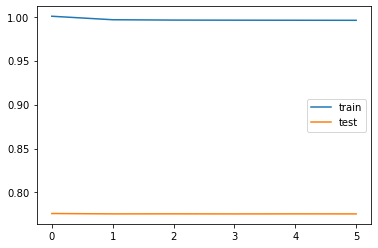

In [299]:
plt.plot(lstm_history.history["loss"], label="train")
plt.plot(lstm_history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [300]:
test_predictions = make_dataset(test_scaled)
test_predictions.as_numpy_iterator()


In [301]:
predictions = lstm_model.predict(make_dataset(test_scaled))
inverse_pred = scaler.inverse_transform(predictions)

In [302]:
output_df = pd.DataFrame(data=inverse_pred, columns=df.columns)

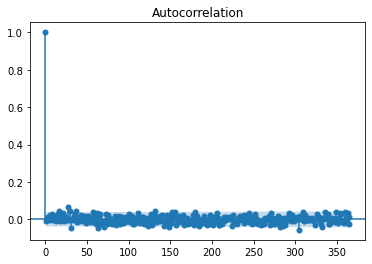

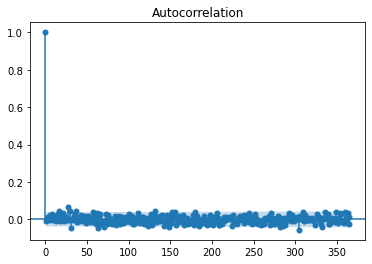

In [303]:
sm.graphics.tsa.plot_acf(output_df["temp"], lags=365)

In [304]:
output_df

,temp,dewp,slp,visib,wdsp,max,min,fog,rain_drizzle,snow_ice_pellets,hail,thunder,year sin,year cos
0,-0.183335,-0.432980,0.232002,-0.058074,-0.004522,-0.154519,0.009224,-0.003668,0.002829,0.000093,-0.000412,0.006881,0.073015,-0.026666
1,-0.513448,-0.560285,0.085463,-0.034779,0.080149,-0.492715,-0.334648,-0.002050,0.008861,-0.000328,-0.000318,-0.007768,-0.023530,-0.064601
2,0.389697,0.242718,0.049811,-0.033133,-0.058160,0.514366,0.204436,-0.000741,0.008020,0.000537,-0.000762,-0.000063,0.084602,-0.021801
3,-0.853122,-0.799975,0.195629,-0.054937,-0.091762,-0.771236,-0.812640,-0.001580,0.000557,-0.000276,0.000221,-0.006293,-0.000798,-0.043647
4,0.813929,0.559615,-0.077243,-0.035856,-0.090203,0.576321,0.648737,-0.004368,0.007033,0.000823,-0.000089,0.002300,0.064465,0.029142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,0.265044,0.231273,-0.077763,0.049129,-0.137546,0.698664,1.126101,-0.014394,-0.002779,0.001459,-0.000539,-0.007786,0.049260,0.028554
2668,0.078706,-0.472152,0.247642,-0.025110,0.012031,-0.112005,0.059782,0.001886,0.014626,-0.000071,-0.000281,-0.001027,0.040866,-0.033941
2669,0.707053,0.455514,-0.325066,0.039477,-0.035328,0.714615,0.599670,-0.015381,0.000888,0.000707,-0.000579,0.000593,-0.016072,0.041241
2670,0.743516,0.690628,-0.008570,0.059961,-0.073361,0.773612,0.575536,-0.011635,-0.002506,0.000454,0.000042,0.000966,0.068397,0.039035


In [305]:

output_df["test temp"] = np.array(test_df[24:]["temp"], dtype="float32")
resid = output_df["temp"] - output_df["test temp"]
resid

0      -26.163334
1      -14.993448
2      -22.050304
3      -39.073124
4      -34.126068
          ...    
2667     5.645044
2668     4.798706
2669     7.067053
2670    -0.896484
2671    -7.368728
Length: 2672, dtype: float32

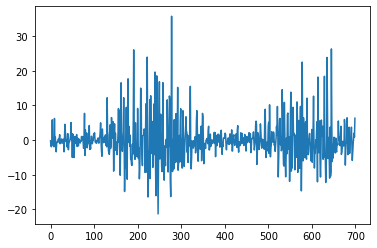